# Hour Manifold Discovery Experiment

## Research Objective

We investigate whether Language Models (specifically GPT-2) represent temporal concepts, specifically the 24-hour cycle, using interpretable topological structures. We test if the internal activation space maps onto specific topological manifolds better than standard baselines.

## Topological Hypotheses

We compare three distinct topological classes against standard baselines:

### 1. Figure-8 Topology (Lemniscates)
Models the 24-hour cycle as two distinct loops (AM/PM) meeting at a central crossing point.
* **rationale:** Captures the linguistic and functional distinction between morning and afternoon/evening while maintaining continuity at midnight.
* **Variants:** Gerono, Bernoulli, and Twisted Lemniscates.

### 2. Toroidal Topology
Models time on the surface of a torus.
* **rationale:** Encodes two nested periodicities (daily cycle + sub-cycles) without self-intersection points.
* **Variants:** Standard Torus paths with varying radii ratios.

### 3. Trefoil Knot ($3_1$ Knot)
A non-trivial knot that winds around a torus surface.
* **rationale:** Represents a complex, self-embedded cycle where the path winds 3 times around the minor axis and 2 times around the major axis.
* **Significance:** Tests for higher-complexity cyclic structures beyond simple circles.

## Methodology

We utilize **Supervised Multidimensional Scaling (SMDS)** to map GPT-2 hidden states to target 3D manifolds.

1.  **Data Generation:**  Synthesized datasets with **2400 samples** (100 per hour) to ensure dense manifold coverage.
    * Varied contexts using 50+ names and 40+ distinct actions.
2.  **Model & Extraction:**  GPT-2 Small.
    * Extraction of hidden states at the temporal token position (Layer 6).
3.  **Manifold Definitions:**  **Baselines:** Standard shapes (Circle, Spiral, Helix, Linear).
    * **Hypotheses:** Analytically defined 3D coordinates for Figure-8, Torus, and Trefoil shapes.
4.  **Evaluation:**  **Train/Test Split (80/20):** Models are fitted on training data; scores are reported on unseen test data to verify structural generalization.
    * **Metric:** Stress score (lower is better), measuring the distortion required to map neural activations to the target geometry.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import GPT2Tokenizer, GPT2Model
from smds import SupervisedMDS, UserProvidedSMDSParametrization
from sklearn.model_selection import train_test_split
from smds.pipeline.discovery_pipeline import discover_manifolds
from smds.shapes.continuous_shapes import (
    CircularShape, EuclideanShape,
    LogLinearShape, SemicircularShape, SpiralShape
)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from smds.shapes.discrete_shapes import (
    ChainShape, ClusterShape, DiscreteCircularShape,
)
import pandas as pd
from typing import List, Tuple
from pathlib import Path
from PIL import Image
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

/Users/arwinsg/code/supervised-multidimensional-scaling/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Configuration

### Experimental Parameters

- **Random seeds**: Multiple independent datasets to assess consistency
- **Samples per hour**: Balance between statistical power and computational cost
- **GPT-2 layer**: Middle layer (6/12) where semantic representations are typically strongest
- **Cross-validation**: 5-fold to ensure robust generalization

### Data Diversity

We maximize stimulus variability to probe robust representations:
- **4 time formats**: 12-hour AM/PM, 24-hour, o'clock notation, natural language
- **51 unique names**: Avoid tokenization artifacts
- **40 actions**: Diverse semantic contexts

In [2]:
RANDOM_SEEDS = [42, 123, 456, 789, 1024]
N_SAMPLES_PER_HOUR = 30
GPT2_LAYER = 6
N_FOLDS = 5
EXPERIMENT_NAME = "Hour_Manifold_Comprehensive"

NAMES = [
    'Alice', 'Bob', 'Charlie', 'George', 'Kevin', 'Laura', 'Michael', 'Rachel',
    'William', 'Aaron', 'Ian', 'Kyle', 'Martin', 'Rose', 'Marco', 'Andrew',
    'Frank', 'Henry', 'Jack', 'Leon', 'Peter', 'Scott', 'Grant', 'Neil',
    'Dean', 'Hope', 'April', 'Connor', 'Brandon', 'Joy', 'Emily', 'Hunter',
    'Tyler', 'Blake', 'Dallas', 'Walker', 'John', 'Fred', 'Steve', 'Matt',
    'Luke', 'Richard', 'Maria', 'Jerry', 'Robert', 'Mark', 'Max', 'Jason',
    'Alex', 'Josh', 'Ryan'
]

ACTIONS = [
    "walked the dog", "made coffee", "read a book", "went to sleep", 
    "ate lunch", "called a friend", "watched a movie", "wrote a letter",
    "cleaned the house", "went for a run", "cooked dinner", "played the piano",
    "studied for the exam", "watered the plants", "checked emails", "did yoga",
    "baked a cake", "painted a picture", "fixed the car", "shopped for groceries",
    "meditated", "took a shower", "brushed teeth", "turned off the lights",
    "opened the window", "locked the door", "started the meeting", "finished work",
    "planned the trip", "listened to music", "charged the phone", "fed the cat", 
    "drank some tea", "organized the desk", "took a nap", "solved a puzzle", 
    "played chess", "wrote code", "debugged the program", "deployed the app"
]

TIME_FORMATS = [
    "12h_am_pm",
    "24h_colon",
    "12h_oclock",
    "natural"
]

print(f"Experimental Configuration:")
print(f"  Independent datasets: {len(RANDOM_SEEDS)}")
print(f"  Total samples per dataset: {N_SAMPLES_PER_HOUR * 24}")
print(f"  Total samples across all datasets: {N_SAMPLES_PER_HOUR * 24 * len(RANDOM_SEEDS)}")
print(f"  GPT-2 layer: {GPT2_LAYER}/12")
print(f"  Cross-validation folds: {N_FOLDS}")
print(f"\nStimulus Diversity:")
print(f"  Time formats: {len(TIME_FORMATS)}")
print(f"  Unique names: {len(NAMES)}")
print(f"  Unique actions: {len(ACTIONS)}")
print(f"  Theoretical unique sentences: {len(NAMES) * len(ACTIONS) * len(TIME_FORMATS) * 24:,}")

Experimental Configuration:
  Independent datasets: 5
  Total samples per dataset: 720
  Total samples across all datasets: 3600
  GPT-2 layer: 6/12
  Cross-validation folds: 5

Stimulus Diversity:
  Time formats: 4
  Unique names: 51
  Unique actions: 40
  Theoretical unique sentences: 195,840


## 2. Data Generation Functions

### Time Format Conversion

We implement 4 distinct time representations to test format-invariance:

1. **12h_am_pm**: "3pm", "11am" (concise)
2. **24h_colon**: "15:00", "23:00" (international standard)
3. **12h_oclock**: "3 o'clock in the afternoon" (verbose)
4. **natural**: "three in the afternoon" (natural language)


In [3]:
def format_time(hour: int, format_type: str) -> str:
    if format_type == "12h_am_pm":
        if hour == 0:
            return "12am"
        elif hour < 12:
            return f"{hour}am"
        elif hour == 12:
            return "12pm"
        else:
            return f"{hour - 12}pm"
    
    elif format_type == "24h_colon":
        return f"{hour:02d}:00"
    
    elif format_type == "12h_oclock":
        h = hour if hour <= 12 else hour - 12
        h = 12 if h == 0 else h
        period = "morning" if hour < 12 else "afternoon" if hour < 18 else "evening"
        return f"{h} o'clock in the {period}"
    
    elif format_type == "natural":
        numbers = ["zero", "one", "two", "three", "four", "five", "six", "seven",
                   "eight", "nine", "ten", "eleven", "twelve"]
        h = hour if hour <= 12 else hour - 12
        h = 12 if h == 0 else h
        period = "morning" if hour < 12 else "afternoon" if hour < 18 else "evening"
        return f"{numbers[h]} in the {period}"
    
    return str(hour)

def generate_time_dataset(
    n_samples_per_hour: int,
    seed: int,
    time_formats: List[str]
) -> Tuple[List[str], List[int]]:
    sentences = []
    hours = []
    
    rng = np.random.default_rng(seed)
    
    for hour in range(24):
        for _ in range(n_samples_per_hour):
            name = rng.choice(NAMES)
            action = rng.choice(ACTIONS)
            format_type = rng.choice(time_formats)
            time_str = format_time(hour, format_type)
            
            sentence = f"{name} {action} at {time_str}."
            sentences.append(sentence)
            hours.append(hour)
    
    indices = rng.permutation(len(sentences))
    sentences = [sentences[i] for i in indices]
    hours = [hours[i] for i in indices]
    
    return sentences, hours

print("Example sentences with different time formats:")
print()
for fmt in TIME_FORMATS:
    example_hour = 14
    formatted = format_time(example_hour, fmt)
    print(f"  {fmt:15s}: Alice walked the dog at {formatted}.")

print("\nExample sentences across different hours:")
print()
for hour in [0, 6, 12, 18, 23]:
    formatted = format_time(hour, '12h_am_pm')
    print(f"  Hour {hour:2d}: Bob made breakfast at {formatted}.")

Example sentences with different time formats:

  12h_am_pm      : Alice walked the dog at 2pm.
  24h_colon      : Alice walked the dog at 14:00.
  12h_oclock     : Alice walked the dog at 2 o'clock in the afternoon.
  natural        : Alice walked the dog at two in the afternoon.

Example sentences across different hours:

  Hour  0: Bob made breakfast at 12am.
  Hour  6: Bob made breakfast at 6am.
  Hour 12: Bob made breakfast at 12pm.
  Hour 18: Bob made breakfast at 6pm.
  Hour 23: Bob made breakfast at 11pm.


## 3. Load GPT-2 Model

We use GPT-2 (small, 117M parameters):

In [4]:
print("Loading GPT-2 model...")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
model.eval()

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"\nModel loaded successfully:")
print(f"  Architecture: {model.config.model_type}")
print(f"  Hidden size: {model.config.hidden_size}")
print(f"  Number of layers: {model.config.n_layer}")
print(f"  Number of attention heads: {model.config.n_head}")
print(f"  Vocabulary size: {model.config.vocab_size:,}")

Loading GPT-2 model...

Model loaded successfully:
  Architecture: gpt2
  Hidden size: 768
  Number of layers: 12
  Number of attention heads: 12
  Vocabulary size: 50,257


**Layer Selection:**
We focus on the **middle layer (Layer 6)** of GPT-2 Small.
* **Rationale:** Research shows that the model learns in a hierarchy: lower layers focus on basic word forms, while middle layers capture grammar and structure. This structural understanding builds the foundation for the complex meanings found in the upper layers (Jawahar et al., 2019).

In [5]:
def extract_hour_activations(
    sentences: List[str],
    layer_idx: int = 6
) -> np.ndarray:
    activations = []
    
    with torch.no_grad():
        for sentence in sentences:
            inputs = tokenizer(sentence, return_tensors='pt', padding=False)
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[layer_idx]
            
            tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
            hour_token_idx = -1
            
            for idx, token in enumerate(tokens):
                token_lower = token.lower()
                if any(x in token_lower for x in ['am', 'pm', ':', 'clock', 'morning', 'afternoon', 'evening']):
                    hour_token_idx = idx
                    break
            
            if hour_token_idx == -1:
                hour_token_idx = -2
            
            activation = hidden_states[0, hour_token_idx, :].numpy()
            activations.append(activation)
    
    return np.array(activations)

## 4. Generate Multiple Datasets and Extract Activations

### Reproducibility Protocol

We generate 5 independent datasets with different random seeds to:
1. Assess consistency of topological structures across stimuli
2. Compute confidence intervals for shape goodness-of-fit
3. Test generalization beyond specific name-action combinations

Each dataset contains (N per hour × 24 hours) samples.

In [6]:
datasets = []

print(f"Generating {len(RANDOM_SEEDS)} independent datasets...\n")
print("="*80)

for seed_idx, seed in enumerate(RANDOM_SEEDS):
    print(f"\nDataset {seed_idx + 1}/{len(RANDOM_SEEDS)} (seed={seed})")
    print("-"*80)
    
    sentences, hours = generate_time_dataset(
        n_samples_per_hour=N_SAMPLES_PER_HOUR,
        seed=seed,
        time_formats=TIME_FORMATS
    )
    
    print(f"  Generated {len(sentences)} sentences")
    print(f"  Example: \"{sentences[0]}\"")
    print(f"  Extracting GPT-2 activations from layer {GPT2_LAYER}...")
    
    X_activations = extract_hour_activations(sentences, layer_idx=GPT2_LAYER)
    
    datasets.append({
        'seed': seed,
        'sentences': sentences,
        'hours': np.array(hours),
        'activations': X_activations
    })
    
    print(f"  Activations shape: {X_activations.shape}")
    print(f"  Statistics: mean={X_activations.mean():.3f}, std={X_activations.std():.3f}")
    print(f"  Range: [{X_activations.min():.3f}, {X_activations.max():.3f}]")

print("\n" + "="*80)
print(f"Total datasets prepared: {len(datasets)}")
print(f"Total samples: {sum(len(d['sentences']) for d in datasets)}")

Generating 5 independent datasets...


Dataset 1/5 (seed=42)
--------------------------------------------------------------------------------
  Generated 720 sentences
  Example: "Dallas watered the plants at 4pm."
  Extracting GPT-2 activations from layer 6...
  Activations shape: (720, 768)
  Statistics: mean=0.084, std=14.209
  Range: [-65.555, 2875.865]

Dataset 2/5 (seed=123)
--------------------------------------------------------------------------------
  Generated 720 sentences
  Example: "William solved a puzzle at 02:00."
  Extracting GPT-2 activations from layer 6...
  Activations shape: (720, 768)
  Statistics: mean=0.078, std=13.635
  Range: [-65.555, 2875.865]

Dataset 3/5 (seed=456)
--------------------------------------------------------------------------------
  Generated 720 sentences
  Example: "Leon played the piano at 4 o'clock in the afternoon."
  Extracting GPT-2 activations from layer 6...
  Activations shape: (720, 768)
  Statistics: mean=0.103, std=15.813
  Ra

## 5. Define Baseline Shapes

### Baseline Hypothesis Set

We test **10 standard baseline configurations** to serve as a reference point for our 3D topological hypotheses. These represent simpler, lower-dimensional structural assumptions:

1. **Continuous (7)**:
   - **Circular (2 variants):** The standard representation of cyclic time (different radii).
   - **Spiral (2 variants):** Combines cyclicity with linear progression (different winding tightness).
   - **Euclidean & LogLinear:** Standard linear regression assumptions.
   - **Semicircular:** Tests for partial cyclicity.

2. **Discrete (3)**:
   - **Chain:** Represents time as a sequential path without cyclicity.
   - **Cluster:** Represents time as unordered, distinct categorical groups.
   - **DiscreteCircular:** A step-wise cyclic representation.

### Configuration Rationale

These baselines test if the model's representation is merely linear or simply cyclic in 2D, before we test the 3D topological hypotheses (Figure-8, Torus).

In [7]:
all_shapes = [
    CircularShape(radious=1.0, normalize_labels=True),
    CircularShape(radious=2.0, normalize_labels=True),
    EuclideanShape(normalize_labels=True),
    LogLinearShape(normalize_labels=True), 
    SpiralShape(initial_radius=0.5, growth_rate=0.1, num_turns=2.0), 
    SpiralShape(initial_radius=0.5, growth_rate=0.1, num_turns=3.0), 
    SemicircularShape(normalize_labels=True),
    ChainShape(threshold=2.0, normalize_labels=False), 
    ClusterShape(),
    DiscreteCircularShape(),
]

print(f"Baseline Shape Configurations: {len(all_shapes)} total\n")
print("="*80)

print("\n1. Continuous Variants (2D/1D):")
print("  - Circular (x2): Standard cyclic clock model (R=1.0, R=2.0)")
print("  - Spiral   (x2): Expanding cycle (2 turns, 3 turns)")
print("  - Linear   (x3): Euclidean, LogLinear (Weber-Fechner), Semicircular")

print("\n2. Discrete Variants:")
print("  - Chain    (x1): Sequential neighbor connectivity")
print("  - Cluster  (x1): Unordered distinct hour states")
print("  - DiscCirc (x1): Step-wise cyclic representation")

print("="*80)

Baseline Shape Configurations: 10 total


1. Continuous Variants (2D/1D):
  - Circular (x2): Standard cyclic clock model (R=1.0, R=2.0)
  - Spiral   (x2): Expanding cycle (2 turns, 3 turns)
  - Linear   (x3): Euclidean, LogLinear (Weber-Fechner), Semicircular

2. Discrete Variants:
  - Chain    (x1): Sequential neighbor connectivity
  - Cluster  (x1): Unordered distinct hour states
  - DiscCirc (x1): Step-wise cyclic representation


## 6. Run Comprehensive Manifold Discovery

### SMDS Pipeline

For each dataset and shape configuration:
1.  **Distance Calculation:** Compute the ideal pairwise distance matrix ($D_{target}$) based on the shape's geometry.
2.  **Optimization:** Find the linear projection ($W$) of the GPT-2 activations that minimizes the stress (difference between activation distances and target distances).
3.  **Cross-Validation:** Train on 80% of the data, evaluate the stress score on the held-out 20% (5-fold CV).
4.  **Aggregation:** Average the normalized stress scores across all folds and datasets.

**Metric:** Score (Higher is better).

**Computational Load:**
The pipeline executes **250 SMDS fits** in total:
* 5 Independent Datasets
* 10 Shape Configurations
* 5 Cross-Validation Folds per shape/dataset

In [9]:
all_results = []
visualization_paths = []

print(f"Running comprehensive manifold discovery...\n")
print(f"Total fits: {len(datasets)} datasets × {len(all_shapes)} shapes × {N_FOLDS} folds = {len(datasets) * len(all_shapes) * N_FOLDS}\n")
print("="*80)

for dataset_idx, dataset in enumerate(datasets):
    print(f"\nDataset {dataset_idx + 1}/{len(datasets)} (seed={dataset['seed']})")
    print("-"*80)
    
    results_df, csv_path = discover_manifolds(
        dataset['activations'],
        dataset['hours'],
        shapes=all_shapes,
        n_folds=N_FOLDS,
        n_jobs=-1,
        experiment_name=f"{EXPERIMENT_NAME}_seed{dataset['seed']}",
        save_results=True,
        create_visualization=True,
        clear_cache=True
    )
    
    results_df['dataset_seed'] = dataset['seed']
    results_df['dataset_idx'] = dataset_idx
    all_results.append(results_df)
    
    if csv_path:
        result_dir = Path(csv_path).parent
        viz_path = result_dir / f"{result_dir.name}_visualized.png"
        if viz_path.exists():
            visualization_paths.append(viz_path)
    
    print(f"\nTop 5 shapes for this dataset:")
    display_cols = [col for col in results_df.columns if any(x in col.lower() for x in ['shape', 'mean', 'stress', 'score'])]
    if display_cols:
        print(results_df[display_cols].head(5).to_string(index=False))

combined_results = pd.concat(all_results, ignore_index=True)
print("\n" + "="*80)
print(f"Discovery complete: {combined_results.shape[0]} total results")
print(f"Visualization plots collected: {len(visualization_paths)}")

Running comprehensive manifold discovery...

Total fits: 5 datasets × 10 shapes × 5 folds = 250


Dataset 1/5 (seed=42)
--------------------------------------------------------------------------------
Saving to: /Users/arwinsg/code/supervised-multidimensional-scaling/smds/pipeline/saved_results/Hour_Manifold_Comprehensive_seed42_2026-01-30_145407_fd067b/Hour_Manifold_Comprehensive_seed42_2026-01-30_145407_fd067b.csv
Computed and cached CircularShape
Computed and cached CircularShape
Computed and cached EuclideanShape
Computed and cached LogLinearShape
Computed and cached SpiralShape
Computed and cached SpiralShape
Computed and cached SemicircularShape
Computed and cached ChainShape
Computed and cached ClusterShape
Computed and cached DiscreteCircularShape
Visual result saved under: /Users/arwinsg/code/supervised-multidimensional-scaling/smds/pipeline/saved_results/Hour_Manifold_Comprehensive_seed42_2026-01-30_145407_fd067b/Hour_Manifold_Comprehensive_seed42_2026-01-30_145407_fd067b_vis

## 7. Display Visualization Plots from Discovery Pipeline

These plots show the top-ranked manifolds for each dataset.

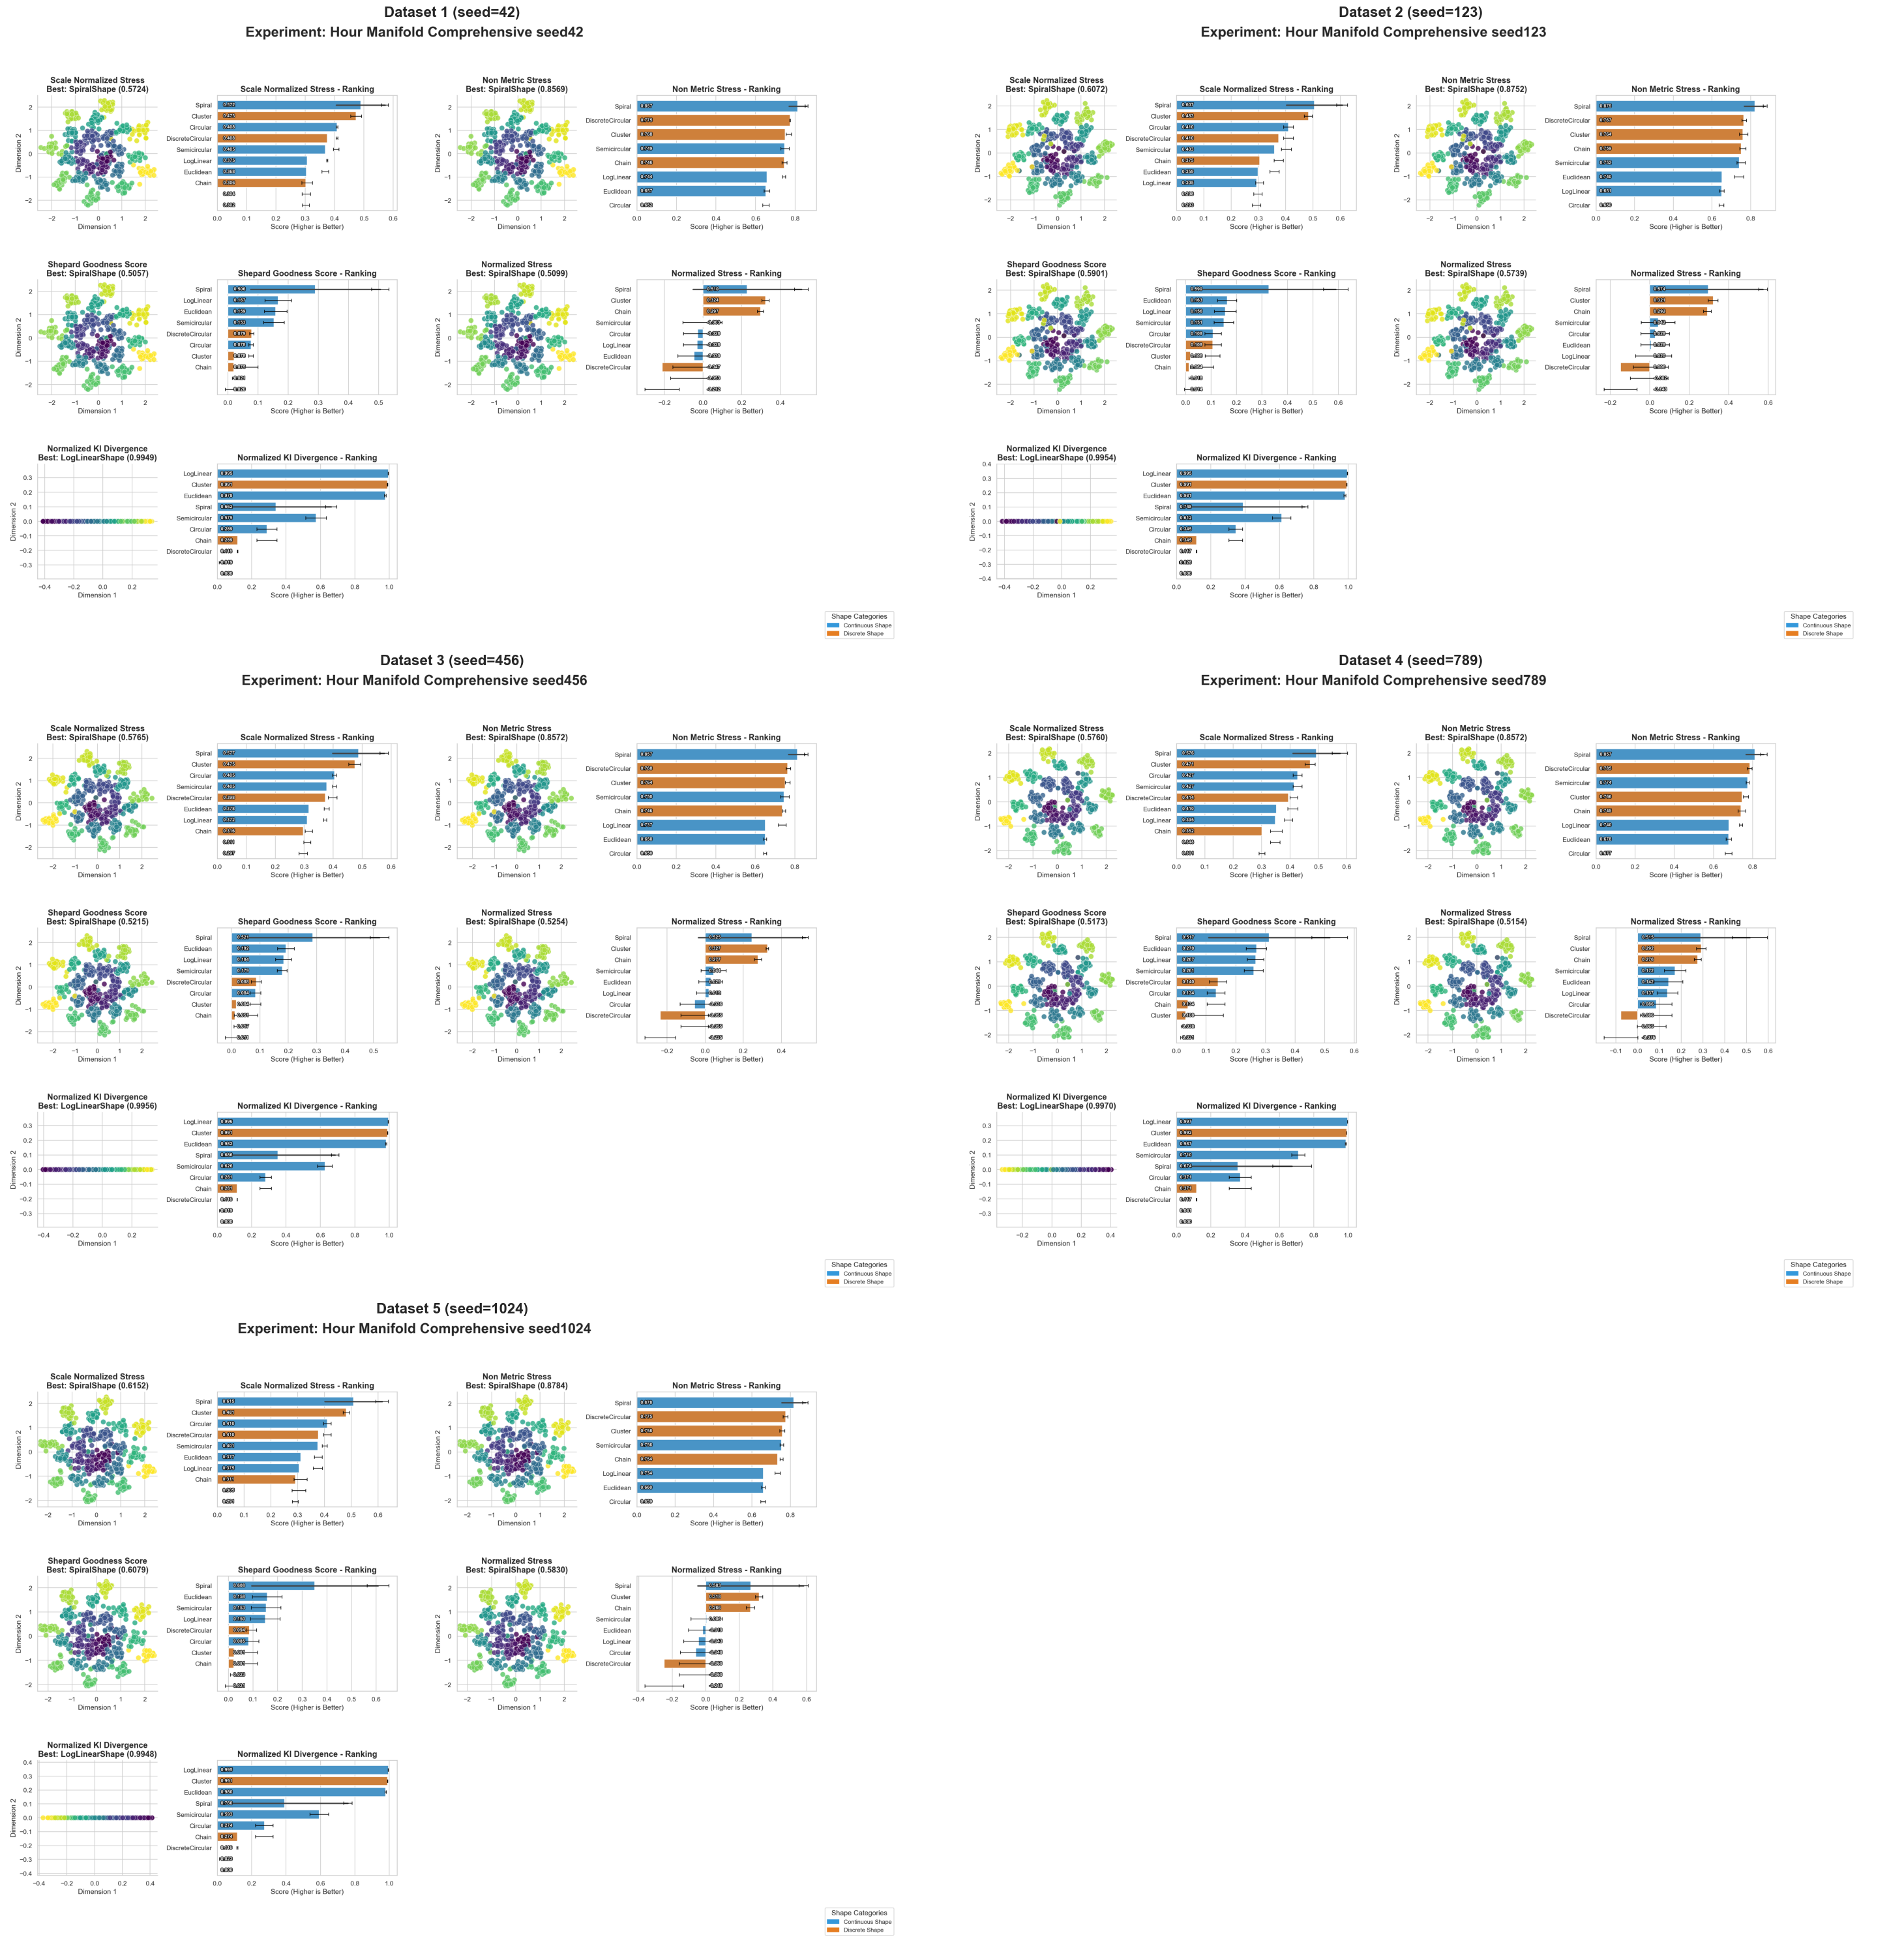

In [10]:
if visualization_paths:
    n_plots = len(visualization_paths)
    n_cols = min(2, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15 * n_cols, 10 * n_rows))
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, viz_path in enumerate(visualization_paths):
        img = Image.open(viz_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"Dataset {idx + 1} (seed={datasets[idx]['seed']})", fontsize=16, fontweight='bold')
    
    for idx in range(len(visualization_paths), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No visualization plots found.")

## 8. Aggregate Results Across All Datasets

### Statistical Aggregation

For each shape, we compute:
- **Mean score**: Central tendency across datasets
- **Std**: Variability 
- **Min/Max**: Range of performance
- **Count**: Number of measurements (should be n_datasets)

**Key metric**: Mean ± Std provides confidence in shape ranking.

In [11]:
shape_col = None
score_col = None

for col in combined_results.columns:
    col_lower = col.lower()
    if 'shape' in col_lower and shape_col is None:
        shape_col = col
    if 'mean' in col_lower and 'stress' in col_lower and score_col is None:
        score_col = col

if shape_col and score_col:
    aggregated = combined_results.groupby(shape_col)[score_col].agg(['mean', 'std', 'min', 'max', 'count']).reset_index()
    aggregated.columns = ['Shape', 'Mean_Score', 'Std_Score', 'Min_Score', 'Max_Score', 'N_Runs']
    aggregated = aggregated.sort_values('Mean_Score', ascending=False)
    aggregated['CV'] = (aggregated['Std_Score'] / aggregated['Mean_Score']) * 100
    
    print("="*120)
    print("AGGREGATED RESULTS: BASELINE SHAPES")
    print("="*120)
    print(f"\nStatistics computed over {len(datasets)} independent datasets")
    print(f"Each shape tested with {N_FOLDS}-fold cross-validation\n")
    print(aggregated.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
    print("\n" + "="*120)
    
    best_shape = aggregated.iloc[0]['Shape']
    best_mean_score = aggregated.iloc[0]['Mean_Score']
    best_std_score = aggregated.iloc[0]['Std_Score']
    best_cv = aggregated.iloc[0]['CV']
    
    print(f"\nBest Standard Shape: {best_shape}")
    print(f"  Mean Score: {best_mean_score:.4f}")
    print(f"  Std: ±{best_std_score:.4f}")
    print(f"  Coefficient of Variation: {best_cv:.1f}%")
    print(f"  95% CI (approx): [{best_mean_score - 2*best_std_score:.4f}, {best_mean_score + 2*best_std_score:.4f}]")
else:
    print("Could not identify shape and score columns for aggregation.")
    print(f"Available columns: {list(combined_results.columns)}")

AGGREGATED RESULTS: BASELINE SHAPES

Statistics computed over 5 independent datasets
Each shape tested with 5-fold cross-validation

                Shape  Mean_Score  Std_Score  Min_Score  Max_Score  N_Runs      CV
          SpiralShape      0.4965     0.0990     0.3983     0.6152      10 19.9338
         ClusterShape      0.4767     0.0052     0.4711     0.4832       5  1.0970
        CircularShape      0.4121     0.0082     0.4048     0.4272      10  1.9887
    SemicircularShape      0.3788     0.0209     0.3594     0.4139       5  5.5081
DiscreteCircularShape      0.3786     0.0091     0.3724     0.3947       5  2.4098
       EuclideanShape      0.3161     0.0211     0.2985     0.3520       5  6.6744
       LogLinearShape      0.3126     0.0210     0.2933     0.3485       5  6.7225
           ChainShape      0.2991     0.0054     0.2910     0.3048       5  1.8090


Best Standard Shape: SpiralShape
  Mean Score: 0.4965
  Std: ±0.0990
  Coefficient of Variation: 19.9%
  95% CI (appro

## 9. Define Specific Manifold Generators

### Mathematical Parametrizations

We directly generate 3D coordinates for five specific manifold variants based on the implementations below:

#### 1. Gerono Lemniscate
Classic figure-8 in 3D with a vertical wave modulation:
$$x(t) = \cos(t)$$
$$y(t) = \sin(t)\cos(t)$$
$$z(t) = 0.5 \sin(t)\sin(t/2)$$

**Mathematical source**: [Wolfram MathWorld: Eight Curve](https://mathworld.wolfram.com/EightCurve.html)

#### 2. Bernoulli Lemniscate
Infinity symbol with saddle curvature:
$$x(t) = \frac{\sqrt{2}\cos(t)}{\sin^2(t) + 1}$$
$$y(t) = \frac{\sqrt{2}\cos(t)\sin(t)}{\sin^2(t) + 1}$$
$$z(t) = \frac{\sin(2t)}{4}$$

**Mathematical source**: [Wolfram MathWorld: Lemniscate](https://mathworld.wolfram.com/Lemniscate.html)

#### 3. Twisted Figure-8
Strongly twisted Lissajous variant:
$$x(t) = \sin(t)$$
$$y(t) = \frac{\sin(2t)}{2}$$
$$z(t) = \sin(t)\cos(t)$$

**Mathematical source**: [Wolfram MathWorld: Lissajous Curve](https://mathworld.wolfram.com/LissajousCurve.html)

**Key property**: All figure-8 variants have a crossing point (self-intersection) at $t=0$ or center, representing the cyclic "midnight" transition.

#### 4. Torus Path (Helical Trace)
A specific path winding around a torus surface:
$$x(t) = (R + r\cos(v))\cos(t)$$
$$y(t) = (R + r\cos(v))\sin(t)$$
$$z(t) = r\sin(v)$$

where:
- $v = \text{ratio} \cdot t$ (determines the winding)
- $R$ = major radius (distance from center to tube center)
- $r$ = minor radius (tube thickness)

**Mathematical source**: [Wolfram MathWorld: Torus](https://mathworld.wolfram.com/Torus.html)

#### 5. Trefoil Knot ($3_1$ Knot)
A non-trivial topological knot with three distinct lobes (scaled by factor $1/3$ for normalization):
$$x(t) = \frac{1}{3} (\sin(t) + 2\sin(2t))$$
$$y(t) = \frac{1}{3} (\cos(t) - 2\cos(2t))$$
$$z(t) = \frac{1}{3} (-\sin(3t))$$

**Mathematical source**: [Wolfram MathWorld: Trefoil Knot](https://mathworld.wolfram.com/TrefoilKnot.html)

**Key properties**:
- **Torus**: No self-intersections (smooth manifold), doubly periodic.
- **Trefoil**: Non-planar, self-intertwined loop without direct self-intersection points.

In [12]:
def generate_figure8_gerono(n_points: int = 1000) -> np.ndarray:
    t = np.linspace(0, 2 * np.pi, n_points)
    x = np.cos(t)
    y = np.sin(t) * np.cos(t)
    z = 0.5 * np.sin(t) * np.sin(t / 2) 
    return np.stack([x, y, z], axis=1)

def generate_figure8_bernoulli(n_points: int = 1000) -> np.ndarray:
    t = np.linspace(-np.pi, np.pi, n_points)
    a = 1.0
    denom = np.sin(t)**2 + 1
    x = a * np.sqrt(2) * np.cos(t) / denom
    y = a * np.sqrt(2) * np.cos(t) * np.sin(t) / denom
    z = np.sin(2 * t) / 4 
    return np.stack([x, y, z], axis=1)

def generate_figure8_twisted(n_points: int = 1000) -> np.ndarray:
    t = np.linspace(0, 2 * np.pi, n_points)
    x = np.sin(t)
    y = np.sin(2 * t) / 2
    z = np.sin(t) * np.cos(t)
    return np.stack([x, y, z], axis=1)

def generate_torus_path(n_points: int = 1000, R: float = 2.0, r: float = 1.0, ratio: float = 1.0) -> np.ndarray:
    t = np.linspace(0, 2 * np.pi, n_points)
    v = ratio * t
    x = (R + r * np.cos(v)) * np.cos(t)
    y = (R + r * np.cos(v)) * np.sin(t)
    z = r * np.sin(v)
    return np.stack([x, y, z], axis=1)

def generate_trefoil_knot(n_points: int = 1000) -> np.ndarray:
    t = np.linspace(0, 2 * np.pi, n_points)
    x = np.sin(t) + 2 * np.sin(2 * t)
    y = np.cos(t) - 2 * np.cos(2 * t)
    z = -np.sin(3 * t)
    return np.stack([x, y, z], axis=1) / 3.0

def map_hours_to_manifold(hours: np.ndarray, manifold_points: np.ndarray) -> np.ndarray:
    n_points = manifold_points.shape[0]
    indices = np.round((hours / 24.0) * (n_points - 1)).astype(int)
    indices = np.clip(indices, 0, n_points - 1)
    return manifold_points[indices]

figure8_configs = [
    ('Gerono', generate_figure8_gerono(200)),
    ('Bernoulli', generate_figure8_bernoulli(200)),
    ('Twisted', generate_figure8_twisted(200)),
    ('Torus_R2_r1', generate_torus_path(200, R=2.0, r=1.0)),
    ('Trefoil_Knot', generate_trefoil_knot(200)),
    ]

print("Topological Hypothesis Configurations")
print("="*80)
print("\nFigure-8 Variants:")
for name, manifold in figure8_configs[:5]:
    print(f"  {name:25s}: {manifold.shape[0]} points in R³")
print("\nToroidal Variants:")
for name, manifold in figure8_configs[5:]:
    print(f"  {name:25s}: {manifold.shape[0]} points in R³")
print("="*80)

Topological Hypothesis Configurations

Figure-8 Variants:
  Gerono                   : 200 points in R³
  Bernoulli                : 200 points in R³
  Twisted                  : 200 points in R³
  Torus_R2_r1              : 200 points in R³
  Trefoil_Knot             : 200 points in R³

Toroidal Variants:


## 10 Visualize Topological Hypotheses

We visualize the generated 3D manifolds to verify their topological properties before using them as targets for the MDS mapping.

The plots below compare:
1.  **Figure-8 Variants:** Gerono, Bernoulli, and Twisted Lemniscates.
2.  **Toroidal Variants:** Torus path and Trefoil Knot.

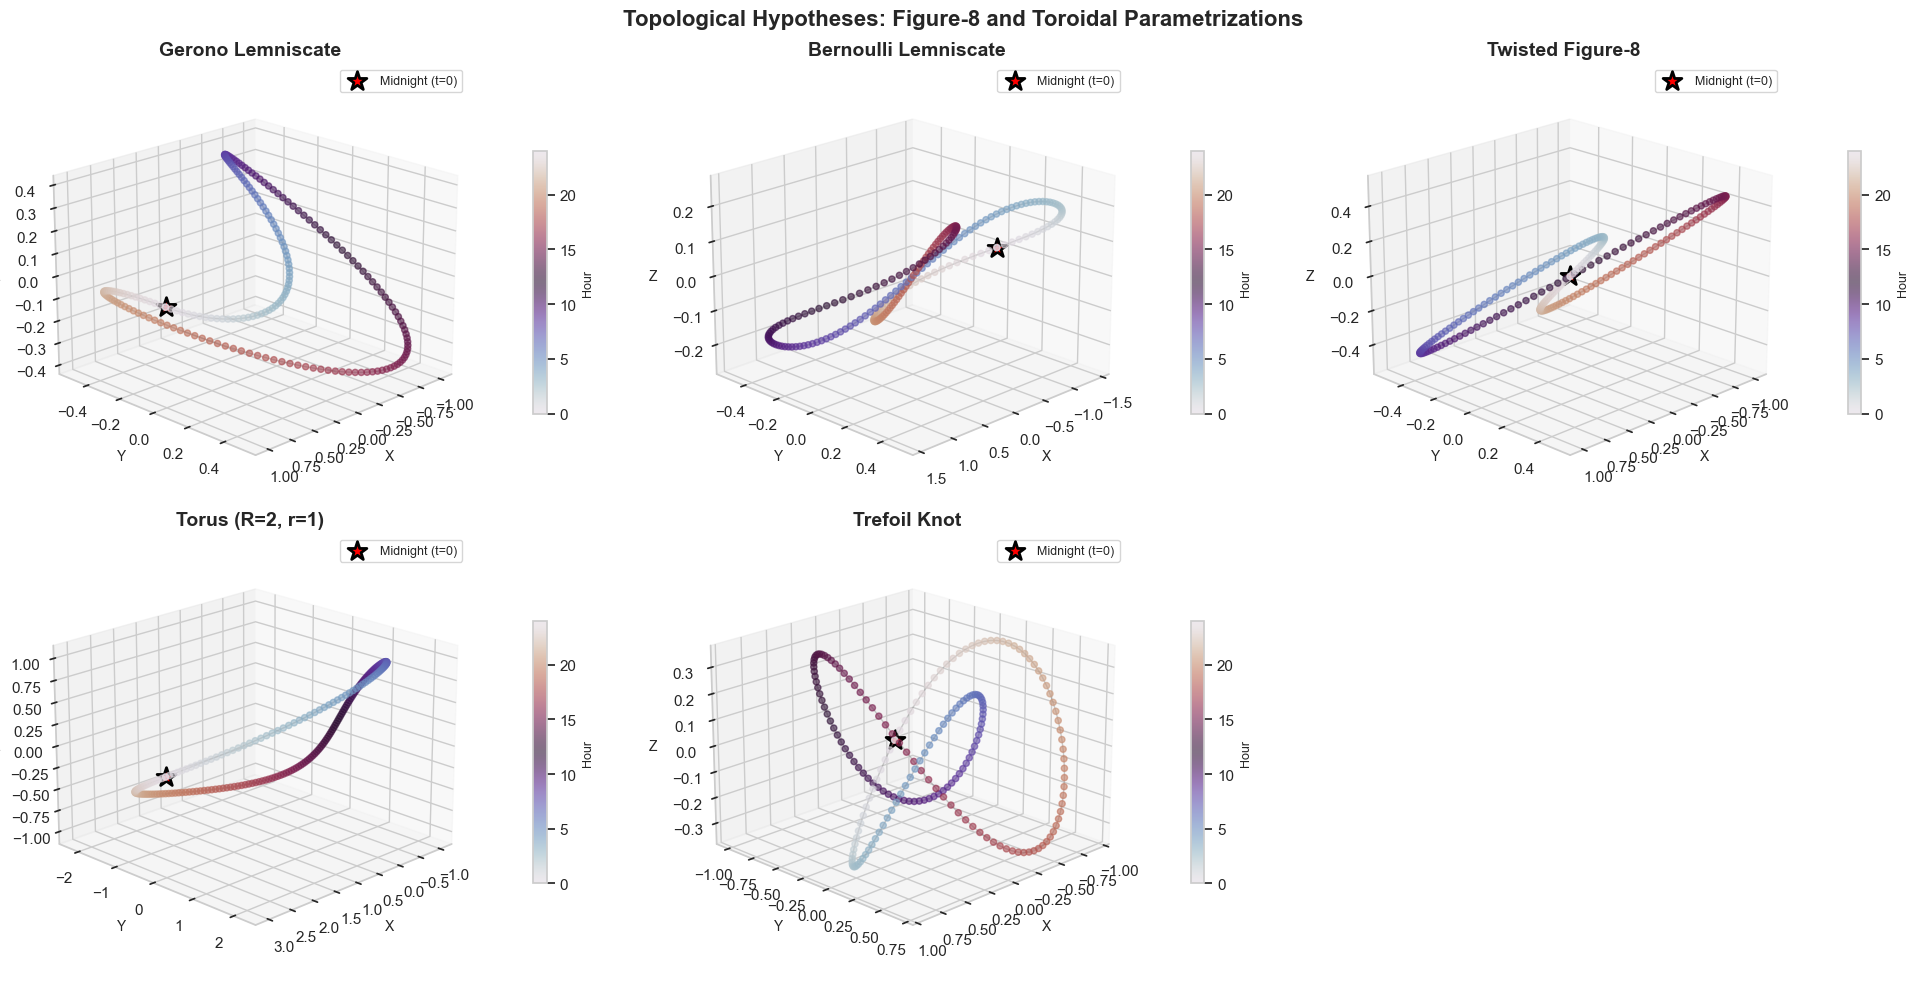

In [13]:
fig = plt.figure(figsize=(20, 10))

selected_configs = [
    ('Gerono Lemniscate', figure8_configs[0][1]),
    ('Bernoulli Lemniscate', figure8_configs[1][1]),
    ('Twisted Figure-8', figure8_configs[2][1]),
    ('Torus (R=2, r=1)', figure8_configs[3][1]),
    ('Trefoil Knot', figure8_configs[4][1]),
    
]

for idx, (name, manifold) in enumerate(selected_configs):
    ax = fig.add_subplot(2, 3, idx + 1, projection='3d')    
    hours_normalized = np.linspace(0, 24, manifold.shape[0])
    scatter = ax.scatter(manifold[:, 0], manifold[:, 1], manifold[:, 2], 
                        c=hours_normalized, cmap='twilight', s=20, alpha=0.6)
    ax.plot(manifold[:, 0], manifold[:, 1], manifold[:, 2], 'gray', linewidth=1, alpha=0.4)
    
    ax.scatter(manifold[0, 0], manifold[0, 1], manifold[0, 2], 
              c='red', s=200, marker='*', edgecolors='black', linewidths=2, 
              label='Midnight (t=0)', zorder=10)
    
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)
    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.legend(fontsize=9)
    ax.view_init(elev=20, azim=45)
    
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Hour', fontsize=9)

plt.suptitle('Topological Hypotheses: Figure-8 and Toroidal Parametrizations', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 11. Test Topological Shapes Hypotheses Using UserProvidedSMDSParametrization

### Direct Coordinate Method

Instead of defining a distance function (as with `BaseShape`), we use the direct coordinate approach:
1. Generate target 3D coordinates directly
2. Map hours to points on the curve
3. Use `UserProvidedSMDSParametrization` to fit the projection from training activations ($X_{train}$) to target coordinates ($Y_{train}$), ensuring the model never sees the test geometry during learning.
4. Evaluate goodness-of-fit with `.score()` method

This method allows testing arbitrary topological hypotheses by specifying target embeddings directly.

In [14]:
bypass_results = []
bypass_visualization_paths = []

print(f"Running comprehensive topological hypothesis discovery (bypass method)...\n")
print(f"Total fits: {len(datasets)} datasets × {len(figure8_configs)} variants = {len(datasets) * len(figure8_configs)}\n")
print("="*80)

for dataset_idx, dataset in enumerate(datasets):
    print(f"\nDataset {dataset_idx + 1}/{len(datasets)} (seed={dataset['seed']})")
    print("-"*80)
    
    X_train, X_test, h_train, h_test = train_test_split(
        dataset['activations'], 
        dataset['hours'], 
        test_size=0.2, 
        random_state=dataset['seed'],
        stratify=dataset['hours']
    )
    
    dataset_results = []
    
    for variant_name, manifold_points in figure8_configs:
        y_train_mapped = map_hours_to_manifold(h_train, manifold_points)
        y_test_mapped = map_hours_to_manifold(h_test, manifold_points)
        
        smds_model = SupervisedMDS(
            stage_1=UserProvidedSMDSParametrization(y=y_train_mapped, n_components=3),
        )
        
        smds_model.fit(X_train, y_train_mapped)
        
        original_Y = smds_model.stage_1_fitted_.Y_.copy()
        smds_model.stage_1_fitted_.Y_ = y_test_mapped
        test_score = smds_model.score(X_test, y_test_mapped)
        smds_model.stage_1_fitted_.Y_ = original_Y
        
        dataset_results.append({
            'dataset_seed': dataset['seed'],
            'dataset_idx': dataset_idx,
            'variant': variant_name,
            'score': test_score
        })
        
        print(f"  {variant_name:25s}: Test Score = {test_score:.4f}")
    
    results_df = pd.DataFrame(dataset_results)
    results_df['dataset_seed'] = dataset['seed']
    results_df['dataset_idx'] = dataset_idx
    bypass_results.append(results_df)
    
    print(f"\nTop 3 variants for this dataset:")
    top_3 = results_df.nlargest(3, 'score')[['variant', 'score']]
    print(top_3.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

bypass_combined_results = pd.concat(bypass_results, ignore_index=True)
print("\n" + "="*80)
print(f"Topological hypothesis discovery complete: {bypass_combined_results.shape[0]} total results")
print(f"Variants tested: {len(figure8_configs)}")
print("="*80)

Running comprehensive topological hypothesis discovery (bypass method)...

Total fits: 5 datasets × 5 variants = 25


Dataset 1/5 (seed=42)
--------------------------------------------------------------------------------
  Gerono                   : Test Score = 0.3869
  Bernoulli                : Test Score = 0.3405
  Twisted                  : Test Score = 0.4043
  Torus_R2_r1              : Test Score = 0.4254
  Trefoil_Knot             : Test Score = 0.5414

Top 3 variants for this dataset:
     variant  score
Trefoil_Knot 0.5414
 Torus_R2_r1 0.4254
     Twisted 0.4043

Dataset 2/5 (seed=123)
--------------------------------------------------------------------------------
  Gerono                   : Test Score = 0.4315
  Bernoulli                : Test Score = 0.3686
  Twisted                  : Test Score = 0.4403
  Torus_R2_r1              : Test Score = 0.4402
  Trefoil_Knot             : Test Score = 0.6026

Top 3 variants for this dataset:
     variant  score
Trefoil_Knot 0.6

## 12 Score Overview for Topological Hypotheses

Comprehensive visualization and summary of all Figure-8 and Torus hypothesis testing results across all datasets, similar to the baseline manifold discovery pipeline.

AGGREGATED RESULTS: TOPOLOGICAL HYPOTHESES (FIGURE-8 & TORUS) - BYPASS METHOD

Statistics computed over 5 independent datasets

     Variant  Mean_Score  Std_Score  Min_Score  Max_Score  N_Runs     CV
Trefoil_Knot      0.5727     0.0262     0.5414     0.6026       5 4.5667
     Twisted      0.4327     0.0206     0.4043     0.4607       5 4.7710
 Torus_R2_r1      0.4249     0.0227     0.3868     0.4441       5 5.3420
      Gerono      0.3992     0.0316     0.3513     0.4315       5 7.9111
   Bernoulli      0.3526     0.0192     0.3258     0.3705       5 5.4318


Best Topological Hypothesis (Bypass Method): Trefoil_Knot
  Mean Score: 0.5727
  Std: 0.0262
  CV: 4.57%
  95% CI (approx): [0.5204, 0.6250]


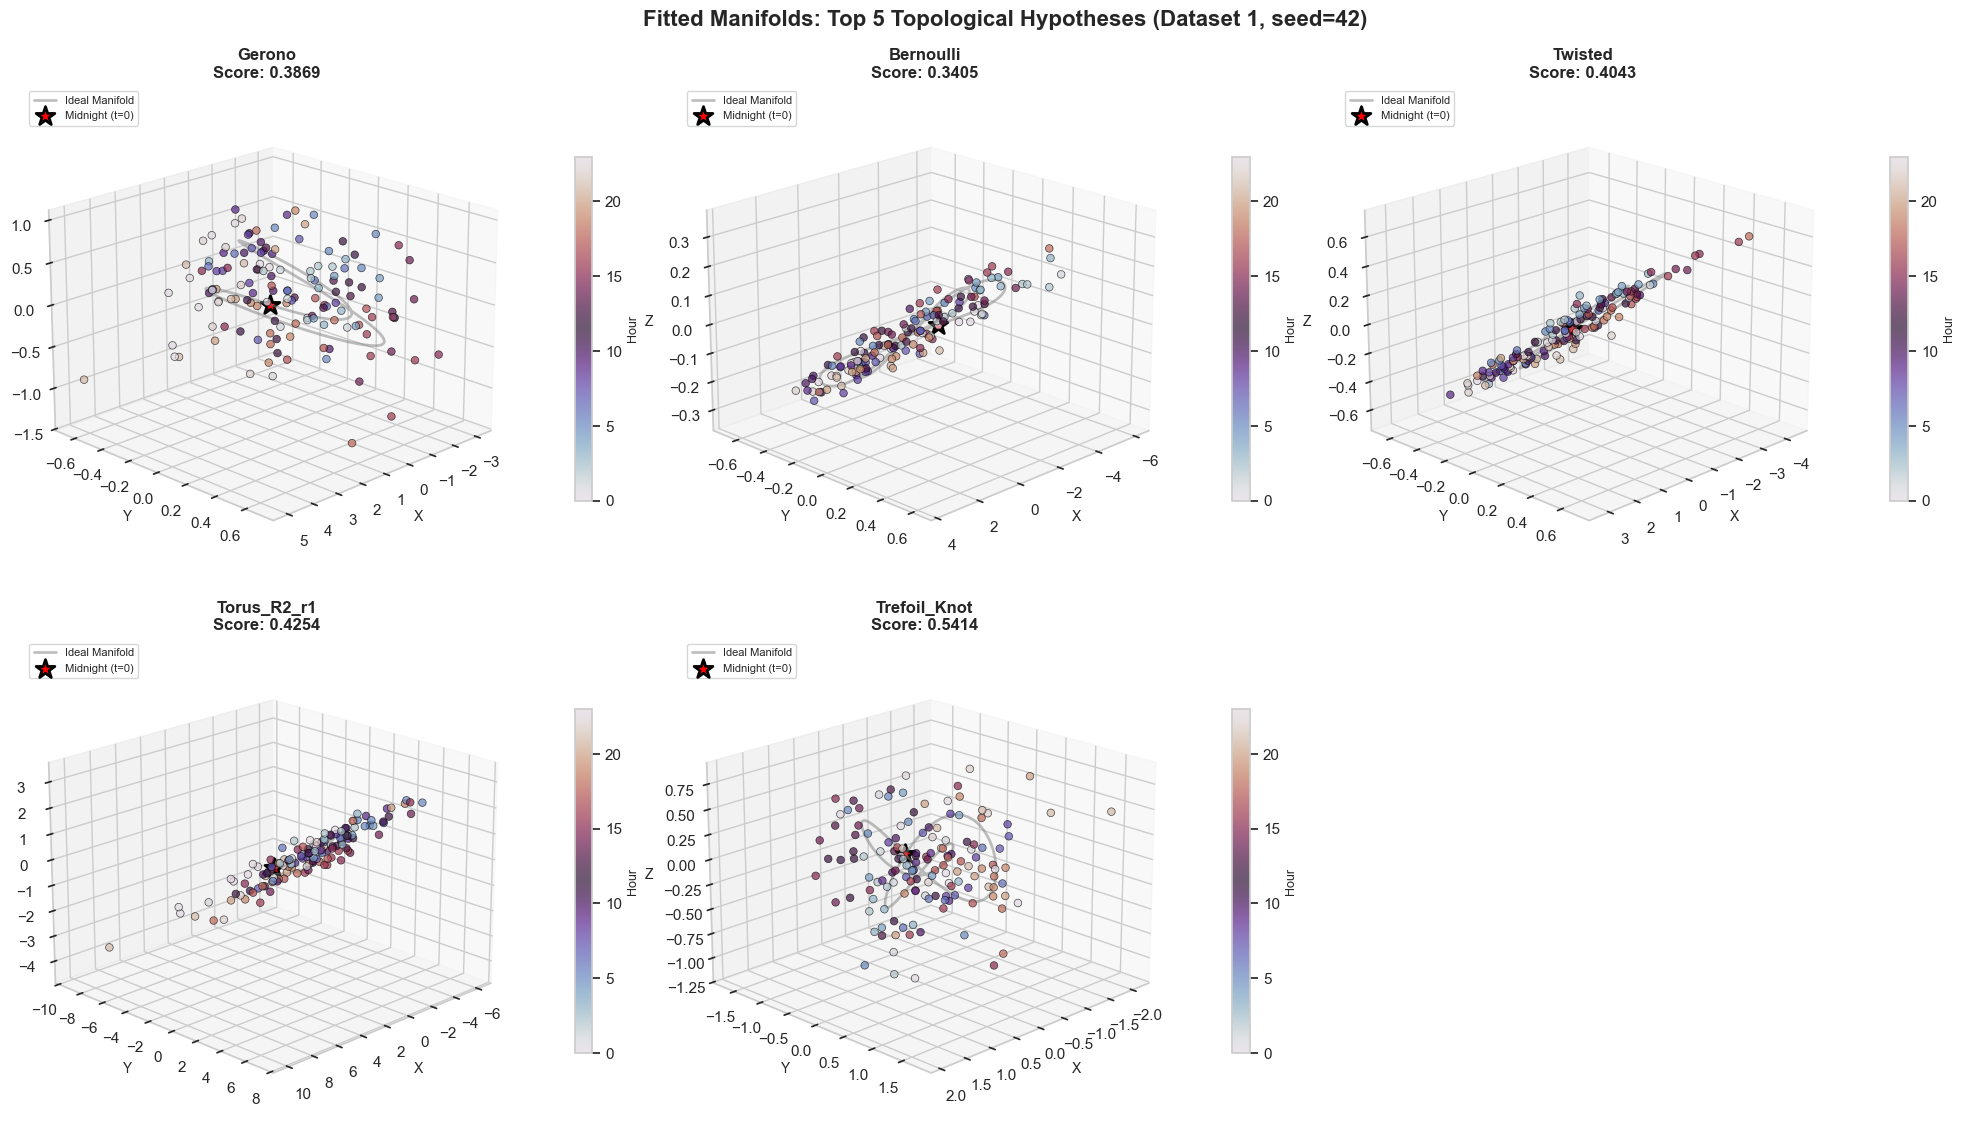

In [15]:
bypass_aggregated = bypass_combined_results.groupby('variant')['score'].agg(['mean', 'std', 'min', 'max', 'count']).reset_index()
bypass_aggregated.columns = ['Variant', 'Mean_Score', 'Std_Score', 'Min_Score', 'Max_Score', 'N_Runs']
bypass_aggregated = bypass_aggregated.sort_values('Mean_Score', ascending=False)
bypass_aggregated['CV'] = (bypass_aggregated['Std_Score'] / bypass_aggregated['Mean_Score']) * 100

print("="*120)
print("AGGREGATED RESULTS: TOPOLOGICAL HYPOTHESES (FIGURE-8 & TORUS) - BYPASS METHOD")
print("="*120)
print(f"\nStatistics computed over {len(datasets)} independent datasets\n")
print(bypass_aggregated.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("\n" + "="*120)

best_bypass_variant = bypass_aggregated.iloc[0]['Variant']
best_bypass_score = bypass_aggregated.iloc[0]['Mean_Score']
best_bypass_std = bypass_aggregated.iloc[0]['Std_Score']
best_bypass_cv = bypass_aggregated.iloc[0]['CV']

print(f"\nBest Topological Hypothesis (Bypass Method): {best_bypass_variant}")
print(f"  Mean Score: {best_bypass_score:.4f}")
print(f"  Std: {best_bypass_std:.4f}")
print(f"  CV: {best_bypass_cv:.2f}%")
print(f"  95% CI (approx): [{best_bypass_score - 2*best_bypass_std:.4f}, {best_bypass_score + 2*best_bypass_std:.4f}]")

top_variants = bypass_aggregated.head(6)['Variant'].tolist()
selected_bypass_configs = [(name, points) for name, points in figure8_configs if name in top_variants]

n_plots = len(selected_bypass_configs)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

dataset_idx_to_plot = 0
dataset = datasets[dataset_idx_to_plot]
X_train, X_test, h_train, h_test = train_test_split(
    dataset['activations'], 
    dataset['hours'], 
    test_size=0.2, 
    random_state=dataset['seed'],
    stratify=dataset['hours']
)

fig = plt.figure(figsize=(20, 6 * n_rows))

for idx, (variant_name, manifold_points) in enumerate(selected_bypass_configs):
    y_train_mapped = map_hours_to_manifold(h_train, manifold_points)
    y_test_mapped = map_hours_to_manifold(h_test, manifold_points)
    
    smds_model = SupervisedMDS(
        stage_1=UserProvidedSMDSParametrization(y=y_train_mapped, n_components=3),
    )
    smds_model.fit(X_train, y_train_mapped)
    
    X_test_proj = smds_model.transform(X_test)
    hours_normalized = h_test
    
    score = bypass_combined_results[
        (bypass_combined_results['variant'] == variant_name) & 
        (bypass_combined_results['dataset_seed'] == dataset['seed'])
    ]['score'].values[0]
    
    ax = fig.add_subplot(n_rows, n_cols, idx + 1, projection='3d')
    scatter_fitted = ax.scatter(X_test_proj[:, 0], X_test_proj[:, 1], X_test_proj[:, 2], 
                                c=hours_normalized, cmap='twilight', s=30, alpha=0.7, 
                                edgecolors='black', linewidths=0.5)
    ax.plot(manifold_points[:, 0], manifold_points[:, 1], manifold_points[:, 2], 
           'gray', linewidth=2, alpha=0.5, label='Ideal Manifold')
    ax.scatter(manifold_points[0, 0], manifold_points[0, 1], manifold_points[0, 2], 
              c='red', s=200, marker='*', edgecolors='black', linewidths=2, 
              label='Midnight (t=0)', zorder=10)
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)
    ax.set_title(f'{variant_name}\nScore: {score:.4f}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='upper left')
    ax.view_init(elev=20, azim=45)
    cbar = plt.colorbar(scatter_fitted, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Hour', fontsize=9)

plt.suptitle(f'Fitted Manifolds: Top {n_plots} Topological Hypotheses (Dataset {dataset_idx_to_plot + 1}, seed={dataset["seed"]})', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 13. Statistical Comparison: Hypotheses vs. Baselines

### Statistical Significance Testing

**Objective:** Rigorously determine if the proposed topological models (Figure-8, Torus, Trefoil) provide a significantly better fit than the best-performing standard baseline.

**Formal Hypothesis:**
* **Null Hypothesis ($H_0$):** The proposed topological hypothesis yields a stress score equal to or worse (higher) than the best baseline model.
* **Alternative Hypothesis ($H_1$):** The proposed topological hypothesis yields a statistically significantly lower stress score (better fit).

**Method:** Independent two-sample t-test (one-tailed) comparing the distribution of stress scores across all cross-validation folds and seeds.

In [18]:
if 'aggregated' not in locals() or aggregated.empty:
    print("Error: 'aggregated' dataframe not found or empty. Please run previous cells.")
elif 'combined_results' not in locals():
    print("Error: 'combined_results' not found. Please run previous cells.")
elif 'bypass_combined_results' not in locals() or bypass_combined_results.empty:
    print("Error: 'bypass_combined_results' not found or empty. Please run previous cells.")
else:
    shape_col = None
    for col in combined_results.columns:
        if 'shape' in col.lower():
            shape_col = col
            break
    
    score_col = None
    for col in combined_results.columns:
        col_lower = col.lower()
        if 'mean' in col_lower and 'stress' in col_lower:
            score_col = col
            break
    
    if not shape_col or not score_col:
        print(f"Error: Could not find required columns in combined_results")
        print(f"Available columns: {list(combined_results.columns)}")
    else:
        if 'bypass_aggregated' not in locals() or bypass_aggregated.empty:
            bypass_aggregated = bypass_combined_results.groupby('variant')['score'].agg(['mean', 'std', 'min', 'max', 'count']).reset_index()
            bypass_aggregated.columns = ['Variant', 'Mean_Score', 'Std_Score', 'Min_Score', 'Max_Score', 'N_Runs']
            bypass_aggregated = bypass_aggregated.sort_values('Mean_Score', ascending=False)
        
        best_hypothesis = bypass_aggregated.iloc[0]['Variant']
        best_standard_shape = aggregated.iloc[0]['Shape']
        
        standard_scores = combined_results[combined_results[shape_col] == best_standard_shape][score_col].values
        hypothesis_scores = bypass_combined_results[bypass_combined_results['variant'] == best_hypothesis]['score'].values
        
        if len(hypothesis_scores) == 0:
            print(f"Error: No scores found for hypothesis '{best_hypothesis}'")
        elif len(standard_scores) == 0:
            print(f"Error: No scores found for baseline '{best_standard_shape}'")
        else:
            t_stat, p_value = stats.ttest_ind(hypothesis_scores, standard_scores, alternative='greater')
            
            hyp_type = "Torus" if 'Torus' or 'Trefoil' in best_hypothesis else "Figure-8"
            pooled_std = np.sqrt((standard_scores.std()**2 + hypothesis_scores.std()**2) / 2)
            cohens_d = (hypothesis_scores.mean() - standard_scores.mean()) / pooled_std
            
            sig_level = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'n.s.'
            effect_size_label = 'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'
            
            print("="*100)
            print("STATISTICAL COMPARISON: BASELINE vs TOPOLOGICAL HYPOTHESES")
            print("="*100)
            print(f"\nBest Standard Shape: {best_standard_shape}")
            print(f"  Mean: {standard_scores.mean():.4f} ± {standard_scores.std():.4f}")
            print(f"  n = {len(standard_scores)}")
            print(f"\nBest Topological Hypothesis: {best_hypothesis} ({hyp_type})")
            print(f"  Mean: {hypothesis_scores.mean():.4f} ± {hypothesis_scores.std():.4f}")
            print(f"  n = {len(hypothesis_scores)}")
            print(f"\nTwo-sample t-test (one-tailed, H1: hypothesis > baseline):")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.6f}")
            print(f"  Significance: {sig_level}")
            
            if p_value < 0.05:
                print(f"\n✓ {hyp_type} hypothesis is SUPPORTED (p < 0.05)")
            else:
                print(f"\n✗ {hyp_type} hypothesis is NOT supported (p >= 0.05)")
            
            print(f"\nCohen's d (effect size): {cohens_d:.3f}")
            print(f"  Interpretation: {effect_size_label} effect")
            print("\n" + "="*100)

STATISTICAL COMPARISON: BASELINE vs TOPOLOGICAL HYPOTHESES

Best Standard Shape: SpiralShape
  Mean: 0.4965 ± 0.0939
  n = 10

Best Topological Hypothesis: Trefoil_Knot (Torus)
  Mean: 0.5727 ± 0.0234
  n = 5

Two-sample t-test (one-tailed, H1: hypothesis > baseline):
  t-statistic: 1.6643
  p-value: 0.059974
  Significance: n.s.

✗ Torus hypothesis is NOT supported (p >= 0.05)

Cohen's d (effect size): 1.114
  Interpretation: large effect



## 14. Comprehensive Visualizations

### 14.1 Score Distribution Comparison

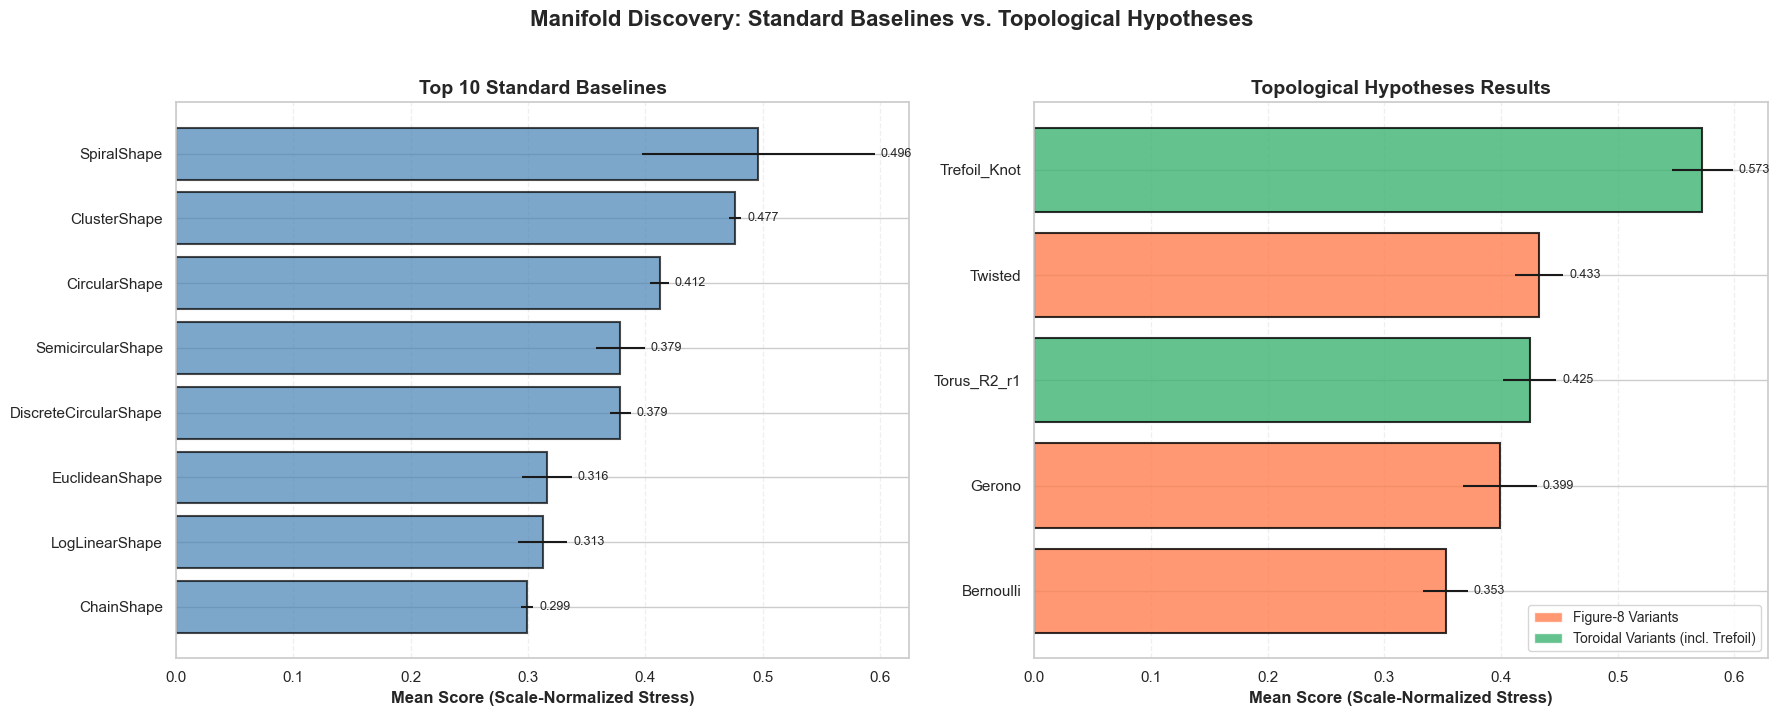

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

if 'aggregated' in locals() and not aggregated.empty:
    top_n = 10
    top_shapes = aggregated.head(top_n)
    
    bars1 = ax1.barh(range(len(top_shapes)), top_shapes['Mean_Score'], 
                     xerr=top_shapes['Std_Score'], alpha=0.7, color='steelblue', 
                     edgecolor='black', linewidth=1.5)
    ax1.set_yticks(range(len(top_shapes)))
    ax1.set_yticklabels(top_shapes['Shape'], fontsize=11)
    ax1.set_xlabel('Mean Score (Scale-Normalized Stress)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Top {top_n} Standard Baselines', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    
    for i, (score, std) in enumerate(zip(top_shapes['Mean_Score'], top_shapes['Std_Score'])):
        ax1.text(score + std + 0.005, i, f'{score:.3f}', va='center', fontsize=9)

if bypass_aggregated is not None:
    colors = []
    for v in bypass_aggregated['Variant']:
        if 'Torus' in v or 'Trefoil' in v:
            colors.append('mediumseagreen')
        else:
            colors.append('coral')
            
    bars2 = ax2.barh(range(len(bypass_aggregated)), bypass_aggregated['Mean_Score'], 
                     xerr=bypass_aggregated['Std_Score'], alpha=0.8, color=colors,
                     edgecolor='black', linewidth=1.5)
    
    ax2.set_yticks(range(len(bypass_aggregated)))
    ax2.set_yticklabels(bypass_aggregated['Variant'], fontsize=11)
    ax2.set_xlabel('Mean Score (Scale-Normalized Stress)', fontsize=12, fontweight='bold')
    ax2.set_title('Topological Hypotheses Results', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    
    for i, (score, std) in enumerate(zip(bypass_aggregated['Mean_Score'], bypass_aggregated['Std_Score'])):
        ax2.text(score + std + 0.005, i, f'{score:.3f}', va='center', fontsize=9)

    legend_elements = [
        Patch(facecolor='coral', alpha=0.8, label='Figure-8 Variants'),
        Patch(facecolor='mediumseagreen', alpha=0.8, label='Toroidal Variants (incl. Trefoil)')
    ]
    ax2.legend(handles=legend_elements, fontsize=10, loc='lower right')

plt.suptitle('Manifold Discovery: Standard Baselines vs. Topological Hypotheses', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 14.2 Consistency Analysis: Coefficient of Variation

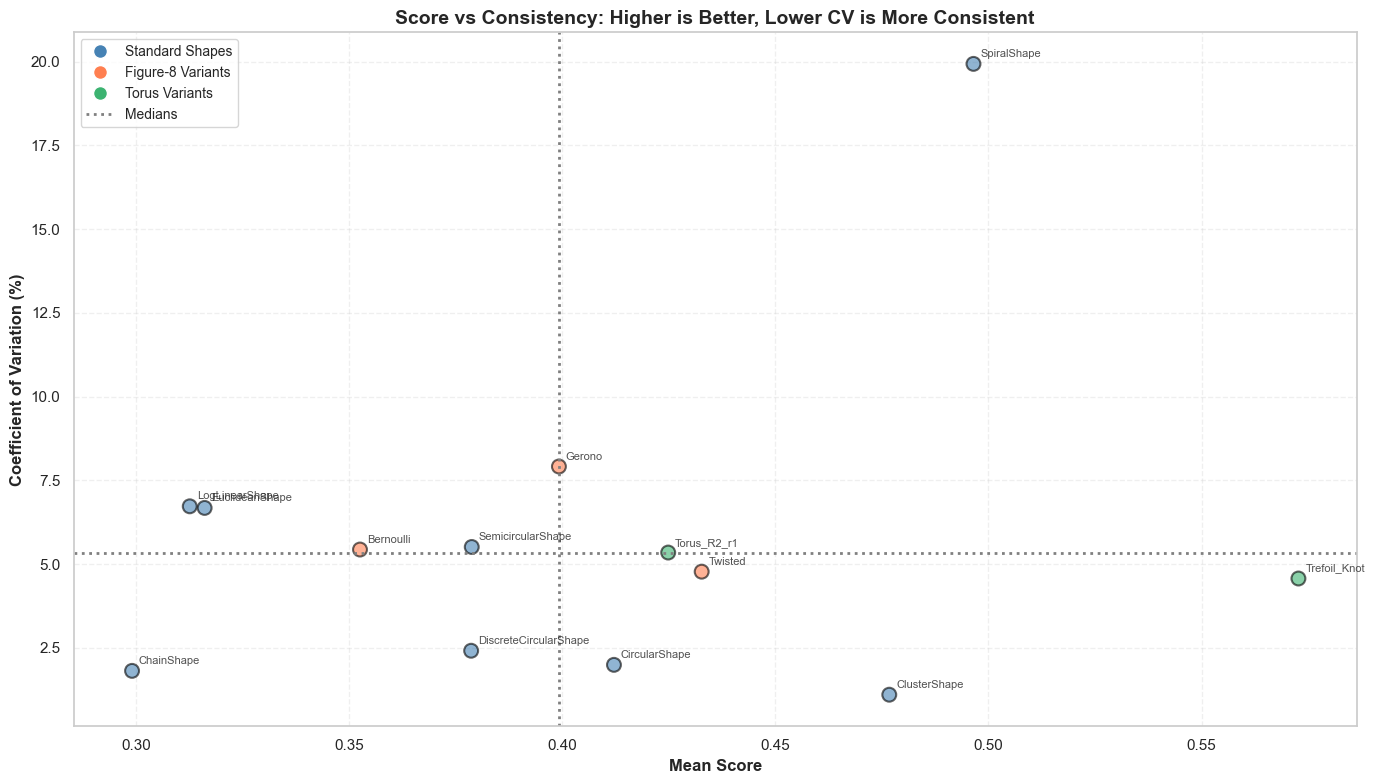

In [20]:
fig, ax = plt.subplots(figsize=(14, 8))

mask_torus_or_trefoil = (
    bypass_aggregated['Variant'].str.contains('Torus', case=False, na=False) | 
    bypass_aggregated['Variant'].str.contains('Trefoil', case=False, na=False)
)
figure8_only = bypass_aggregated[~mask_torus_or_trefoil].copy()
torus_only = bypass_aggregated[mask_torus_or_trefoil].copy()

all_configs = pd.concat([
    aggregated[['Shape', 'Mean_Score', 'CV']].rename(columns={'Shape': 'Config'}).assign(Type='Standard'),
    figure8_only[['Variant', 'Mean_Score', 'CV']].rename(columns={'Variant': 'Config'}).assign(Type='Figure-8'),
    torus_only[['Variant', 'Mean_Score', 'CV']].rename(columns={'Variant': 'Config'}).assign(Type='Torus')
])

color_map = {'Standard': 'steelblue', 'Figure-8': 'coral', 'Torus': 'mediumseagreen'}
colors = [color_map[t] for t in all_configs['Type']]
sizes = 100

scatter = ax.scatter(all_configs['Mean_Score'], all_configs['CV'], 
                     s=sizes, c=colors, alpha=0.6, edgecolors='black', linewidths=1.5)

for idx, row in all_configs.iterrows():
    ax.annotate(row['Config'], (row['Mean_Score'], row['CV']), 
               xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

ax.set_xlabel('Mean Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Coefficient of Variation (%)', fontsize=12, fontweight='bold')
ax.set_title('Score vs Consistency: Higher is Better, Lower CV is More Consistent', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=all_configs['CV'].median(), color='gray', linestyle=':', linewidth=2, label='Median CV')
ax.axvline(x=all_configs['Mean_Score'].median(), color='gray', linestyle=':', linewidth=2, label='Median Score')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=10, label='Standard Shapes'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='coral', markersize=10, label='Figure-8 Variants'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='mediumseagreen', markersize=10, label='Torus Variants'),
    Line2D([0], [0], color='gray', linestyle=':', linewidth=2, label='Medians')
]
ax.legend(handles=legend_elements, fontsize=10, loc='upper left')

plt.tight_layout()
plt.show()


### 14.3 Detailed Distribution: Violin Plots

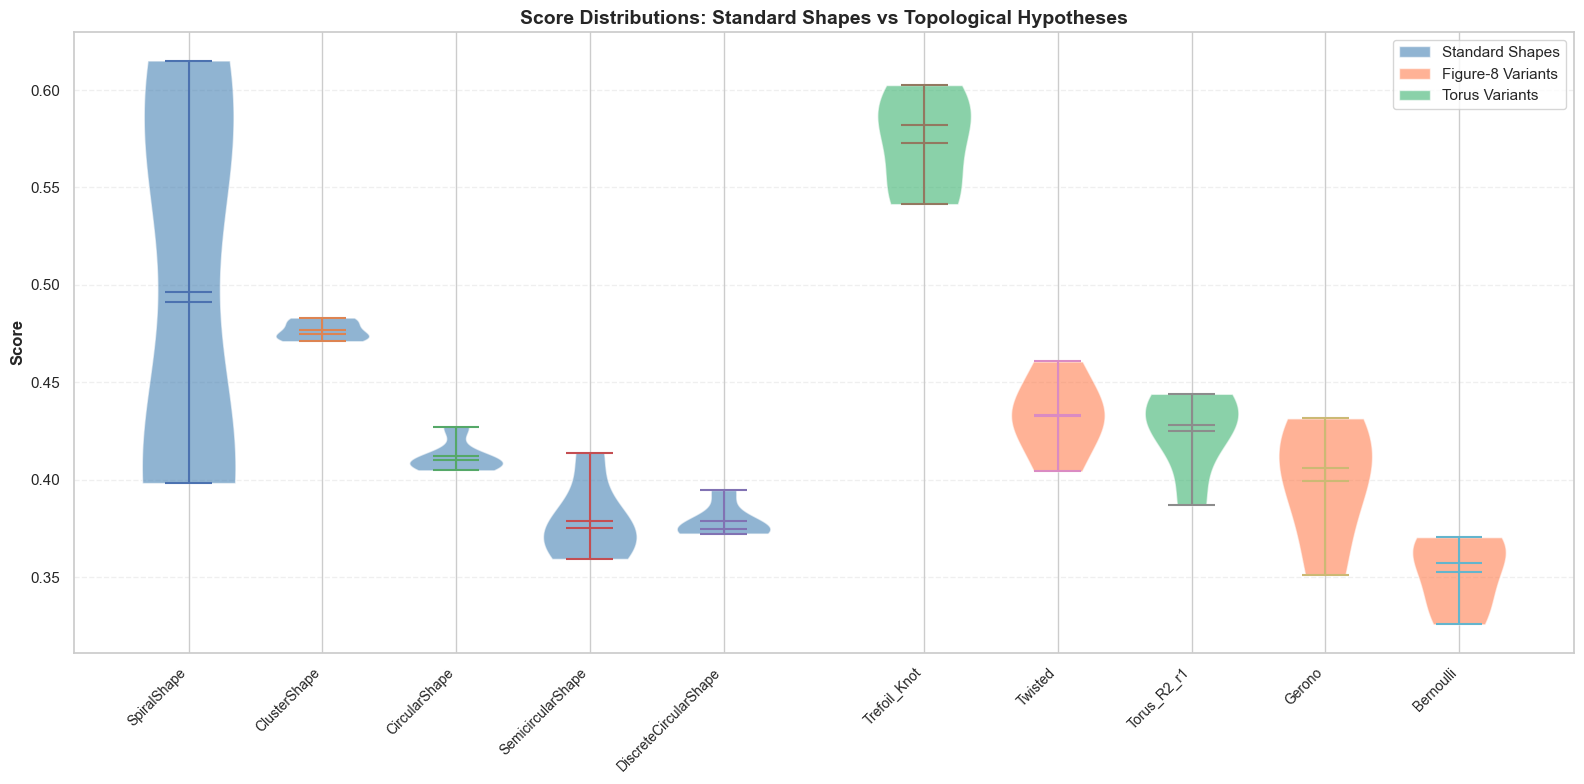


Violin plot interpretation:
  - Width: Distribution density
  - White dot: Median
  - Thick bar: Interquartile range
  - Thin bar: 95% CI


In [21]:
if 'aggregated' in locals() and not aggregated.empty:
    top_5_shapes = aggregated.head(5)['Shape'].tolist()
    
    plot_data = []
    for shape in top_5_shapes:
        scores = combined_results[combined_results[shape_col] == shape][score_col].values
        for score in scores:
            plot_data.append({'Config': shape, 'Score': score, 'Type': 'Standard'})
    
    for variant in bypass_aggregated['Variant']:
        scores = bypass_combined_results[bypass_combined_results['variant'] == variant]['score'].values
        variant_type = 'Torus' if ('Torus' in variant or 'Trefoil' in variant) else 'Figure-8'
        for score in scores:
            plot_data.append({'Config': variant, 'Score': score, 'Type': variant_type})
    
    plot_df = pd.DataFrame(plot_data)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    positions = []
    labels = []
    pos = 0
    
    for shape in top_5_shapes:
        data = plot_df[plot_df['Config'] == shape]['Score'].values
        parts = ax.violinplot([data], positions=[pos], widths=0.7, 
                              showmeans=True, showmedians=True)
        for pc in parts['bodies']:
            pc.set_facecolor('steelblue')
            pc.set_alpha(0.6)
        positions.append(pos)
        labels.append(shape)
        pos += 1
    
    pos += 0.5
    
    for variant in bypass_aggregated['Variant']:
        data = plot_df[plot_df['Config'] == variant]['Score'].values
        parts = ax.violinplot([data], positions=[pos], widths=0.7,
                              showmeans=True, showmedians=True)
        variant_color = 'mediumseagreen' if ('Torus' in variant or 'Trefoil' in variant) else 'coral'
        for pc in parts['bodies']:
            pc.set_facecolor(variant_color)
            pc.set_alpha(0.6)
        positions.append(pos)
        labels.append(variant)
        pos += 1
    
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Score Distributions: Standard Shapes vs Topological Hypotheses', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    legend_elements = [
        Patch(facecolor='steelblue', alpha=0.6, label='Standard Shapes'),
        Patch(facecolor='coral', alpha=0.6, label='Figure-8 Variants'),
        Patch(facecolor='mediumseagreen', alpha=0.6, label='Torus Variants')
    ]
    ax.legend(handles=legend_elements, fontsize=11, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print("\nViolin plot interpretation:")
    print("  - Width: Distribution density")
    print("  - White dot: Median")
    print("  - Thick bar: Interquartile range")
    print("  - Thin bar: 95% CI")

## 15. Final Summary and Conclusions

### Experimental Summary

In [ ]:
print("="*100)
print("EXPERIMENTAL SUMMARY")
print("="*100)

if 'aggregated' in locals() and not aggregated.empty:
    print("\n1. BASELINE SHAPES (Top 5):")
    print("-"*100)
    for idx, row in aggregated.head(5).iterrows():
        print(f"   {idx+1}. {row['Shape']:25s} Score: {row['Mean_Score']:.4f} ± {row['Std_Score']:.4f}")

print("\n2. TOPOLOGICAL HYPOTHESES:")
print("-"*100)
for idx, row in bypass_aggregated.iterrows():
    hyp_type = "Torus" if ("Torus" in row['Variant'] or "Trefoil" in row['Variant']) else "Figure-8"
    print(f"   {idx+1}. {row['Variant']:25s} [{hyp_type:10s}] Score: {row['Mean_Score']:.4f} ± {row['Std_Score']:.4f}")

if 'aggregated' in locals() and not aggregated.empty and 'best_hypothesis' in locals():
    best_hyp_score = bypass_aggregated.iloc[0]['Mean_Score']
    best_hyp_std = bypass_aggregated.iloc[0]['Std_Score']
    best_mean_score = aggregated.iloc[0]['Mean_Score']
    best_std_score = aggregated.iloc[0]['Std_Score']
    best_standard_shape = aggregated.iloc[0]['Shape']
    hyp_type = "Torus" if ("Torus" in best_hypothesis or "Trefoil" in best_hypothesis) else "Figure-8"
    
    score_diff = best_hyp_score - best_mean_score
    improvement_pct = (score_diff / best_mean_score) * 100
    
    print("\n3. BEST COMPARISON:")
    print("-"*100)
    print(f"   Baseline:     {best_standard_shape:25s} {best_mean_score:.4f} ± {best_std_score:.4f}")
    print(f"   Hypothesis:   {best_hypothesis:25s} [{hyp_type}] {best_hyp_score:.4f} ± {best_hyp_std:.4f}")
    print(f"   Difference:   {score_diff:+.4f} ({improvement_pct:+.1f}%)")
    
    if 'p_value' in locals():
        print(f"   t-test:       p = {p_value:.4f}")
        if p_value < 0.05:
            print(f"   Result:       ✓ {hyp_type} hypothesis SUPPORTED (p < 0.05)")
        else:
            print(f"   Result:       ✗ {hyp_type} hypothesis NOT supported (p >= 0.05)")

print("\n4. METHODOLOGY:")
print("-"*100)
print(f"   Model:           GPT-2 Small, Layer {GPT2_LAYER}/12")
print(f"   Datasets:        {len(datasets)} seeds")
print(f"   Samples:         {len(datasets) * N_SAMPLES_PER_HOUR * 24} total")
print(f"   Cross-validation: {N_FOLDS}-fold")
print(f"   Baseline shapes: {len(all_shapes)}")
print(f"   Hypotheses:      {len(figure8_configs)} variants")

print("\n" + "="*100)

EXPERIMENTAL SUMMARY

1. BASELINE SHAPES (Top 5):
----------------------------------------------------------------------------------------------------
   8. SpiralShape               Score: 0.4965 ± 0.0990
   3. ClusterShape              Score: 0.4767 ± 0.0052
   2. CircularShape             Score: 0.4121 ± 0.0082
   7. SemicircularShape         Score: 0.3788 ± 0.0209
   4. DiscreteCircularShape     Score: 0.3786 ± 0.0091

2. TOPOLOGICAL HYPOTHESES:
----------------------------------------------------------------------------------------------------
   4. Trefoil_Knot              [Torus     ] Score: 0.5727 ± 0.0262
   5. Twisted                   [Figure-8  ] Score: 0.4327 ± 0.0206
   3. Torus_R2_r1               [Torus     ] Score: 0.4249 ± 0.0227
   2. Gerono                    [Figure-8  ] Score: 0.3992 ± 0.0316
   1. Bernoulli                 [Figure-8  ] Score: 0.3526 ± 0.0192

3. BEST COMPARISON:
------------------------------------------------------------------------------------